# Analysis Sparsity

Learning to find the optimal dictionary $D$ s.t. $\min_x ||Dx||_\epsilon + \frac{1}{2}||x-f||^2$ is a good denoising of data $f$.

## Imports:

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision

import matplotlib.pyplot as plt
import plotly.offline as ply
import plotly.graph_objs as go
ply.offline.init_notebook_mode(connected=True)

import os
import time
import datetime
from collections import defaultdict
from copy import deepcopy

from IPython.display import clear_output
%load_ext autoreload

from PIL import Image
import bilevelsurrogates as Sur

#ymmv:
torch.backends.cudnn.benchmark = True

### GPU Setup:

In [2]:
device = torch.device('cuda:1')
dtype = torch.float

In [3]:
# Sur.deterministic() # Disable this for reasonable timings, enable to reproduce numbers from paper
# Note that the actual timing depends on the number of iterations of the subproblems, which can vary.

## Data Generation:

Download the data first!!

In [4]:
noise = 25/255
clip = False
batch_size = 200

patch_cropping = torchvision.transforms.RandomCrop((64,64))
#patch_cropping = None

path = os.getcwd() + '/data/BSDS300/' 
datasetTrain = Sur.data.BSDS300_for_denoising(path, noise_std=noise, augmentations=patch_cropping, flip=True,
                                              grayscale=True, clip_to_realistic=clip)
datasetTest = Sur.data.BSDS300_for_denoising(path, split = 'trainingZhang', noise_std=noise,
                                             augmentations=patch_cropping,
                                             flip=True, grayscale=True, clip_to_realistic=clip)
datasetTestFull = Sur.data.BSDS300_for_denoising(path, split = 'testing68Zhang', noise_std=noise,
                                             augmentations=None, flip=True, grayscale=True,
                                             clip_to_realistic=clip)
samples = Sur.data.Samples(datasetTrain, batch_size, device=device, dtype=dtype)

### Example training patches

noisy psnr: 20.17002799987793


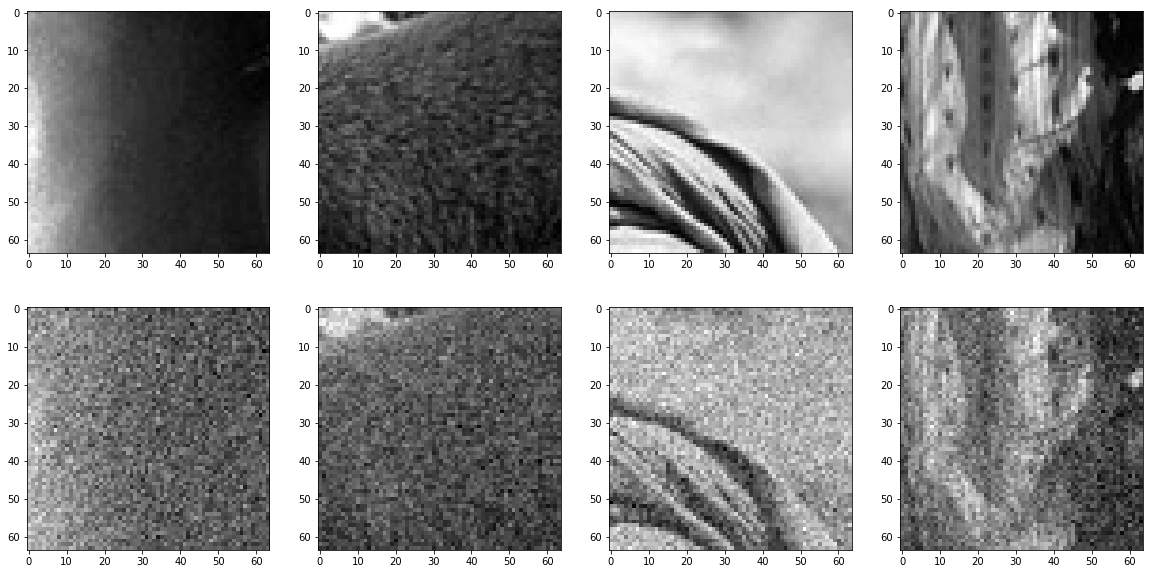

In [5]:
fig, axes = plt.subplots(2,4,figsize=(20, 10))
for idx, img_id in enumerate(np.random.choice(batch_size,4)):
    axes[0,idx].imshow(datasetTrain.unnormalize(samples.x[img_id,0,:,:]).cpu(), cmap='gray')
    axes[1,idx].imshow(datasetTrain.unnormalize(samples.y[img_id,0,:,:]).cpu(), cmap='gray')
fig.canvas.draw()
print(f'noisy psnr: {Sur.psnr_compute(samples.y, samples.x)}')

### Example test images

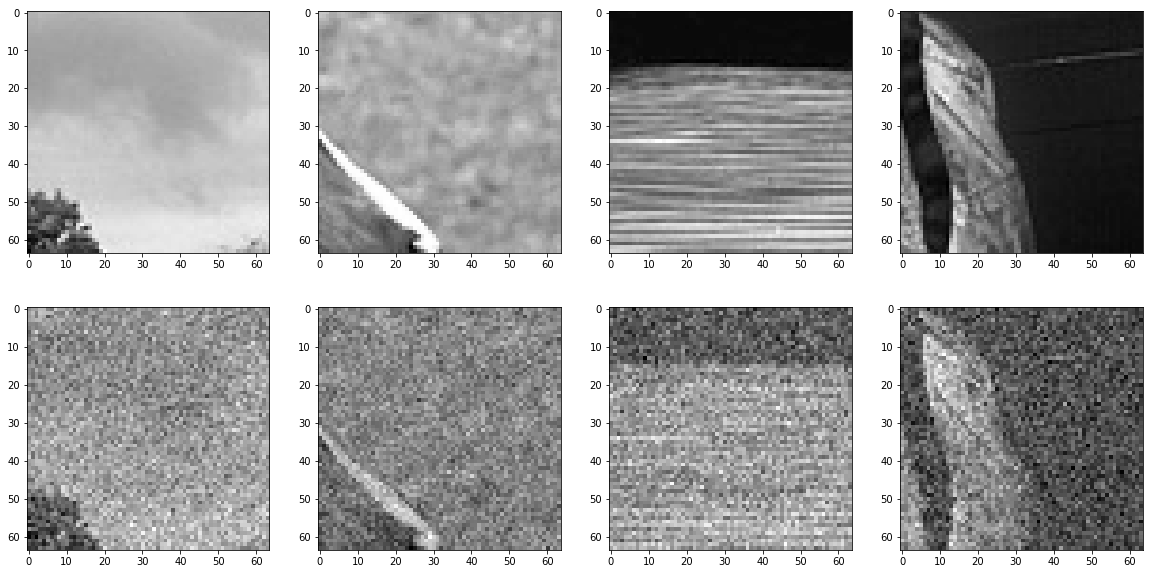

In [6]:
fig, axes = plt.subplots(2,4,figsize=(20, 10))
for idx, img_id in enumerate(np.random.choice(len(datasetTest),4)):
    test_gt, test_noisy = datasetTest[img_id]
    axes[0,idx].imshow(datasetTrain.unnormalize(test_gt[0,:,:]).cpu(), cmap='gray')
    axes[1,idx].imshow(datasetTrain.unnormalize(test_noisy[0,:,:]).cpu(), cmap='gray')
fig.canvas.draw()

# Define Energy Model

In [7]:
model_setup = dict()
model_setup['data'] = dict(dtype=dtype, device=device)

# Sizes:
model_setup['x_dims'] = samples.x.shape

# Hyperparameters:
model_setup['alpha'] = 0.01
model_setup['epsilon'] = 0.0
model_setup['bias'] = False
model_setup['norm'] = 'aniso'
model_setup['clip'] = True

model_setup['inference'] = dict(tolerance=1e-4, max_iterations=250)


# Setups 1, 2, 3 correspond to table 1 in the paper:
setup = 2

# Define Model
def energy_setup(model_setup):
    if setup == 1:
        dictionary = Sur.DCTConvolution(in_channels=1, out_channels=3, kernel_size=3, mean=False,
                                        bias=model_setup['bias']).to(**model_setup['data'])
    elif setup == 2:
        dictionary = Sur.DCTConvolution(in_channels=1, out_channels=48, kernel_size=7, mean=False,
                                        bias=model_setup['bias']).to(**model_setup['data'])
    elif setup == 3:
        dictionary = Sur.DCTConvolution(in_channels=1, out_channels=96, kernel_size=9, mean=False,
                                        bias=model_setup['bias']).to(**model_setup['data'])
        model_setup['alpha'] *= (48*7*7) / (96*9*9)
    elif setup == 4:
        dictionary = Sur.Gradient(in_channels=1, scalable=True).to(**model_setup['data'])
    elif setup == 5:
        dictionary = Sur.DCTConvolution(in_channels=1, out_channels=168, kernel_size=13, mean=False,
                                        bias=model_setup['bias']).to(**model_setup['data'])
        model_setup['alpha'] *= (48*7*7) / (168*13**2)    
    energy = Sur.model.AnalysisSparsity(dictionary, setup=model_setup)
    return energy
energy = energy_setup(model_setup)

## Define Higher-level loss

In [8]:
loss = Sur.loss.PSNR()

# --- Training Algorithms ---

### Visualize initial dictionary

Dictionary norm is 1.000.


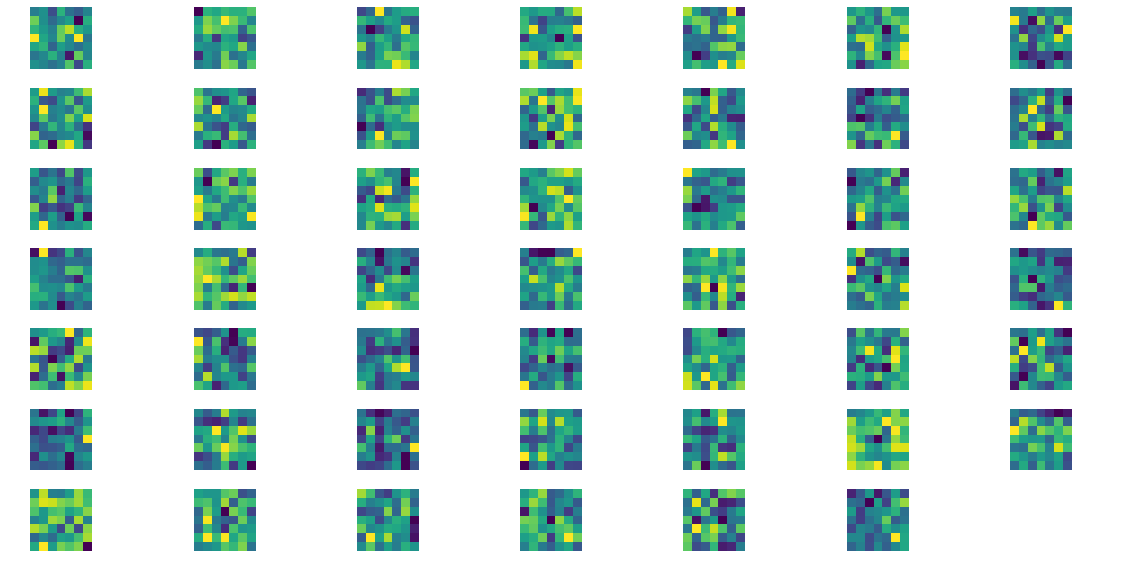

In [9]:
Sur.visualize(energy.operator);

In [10]:
# torch.backends.cudnn.deterministic = False # enable this for non-deterministic timings with det. data selection and init
# torch.backends.cudnn.benchmark = True # enable this for non-deterministic timings with det. data selection and init

# 1) Single step Parametric Majorizer

### Parameters:

In [11]:
algorithm = 'joint-dual'
training_setup = Sur.training.default_setup('DiscriminativeLearning', algorithm)

### Training:

In [12]:
energy = energy_setup(model_setup)
optimizer = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm=algorithm)
optimizer.run();

status: iteration    0, loss: 0.00586 (avg PSNR est: 19.310), tol: 100.000%


### Output

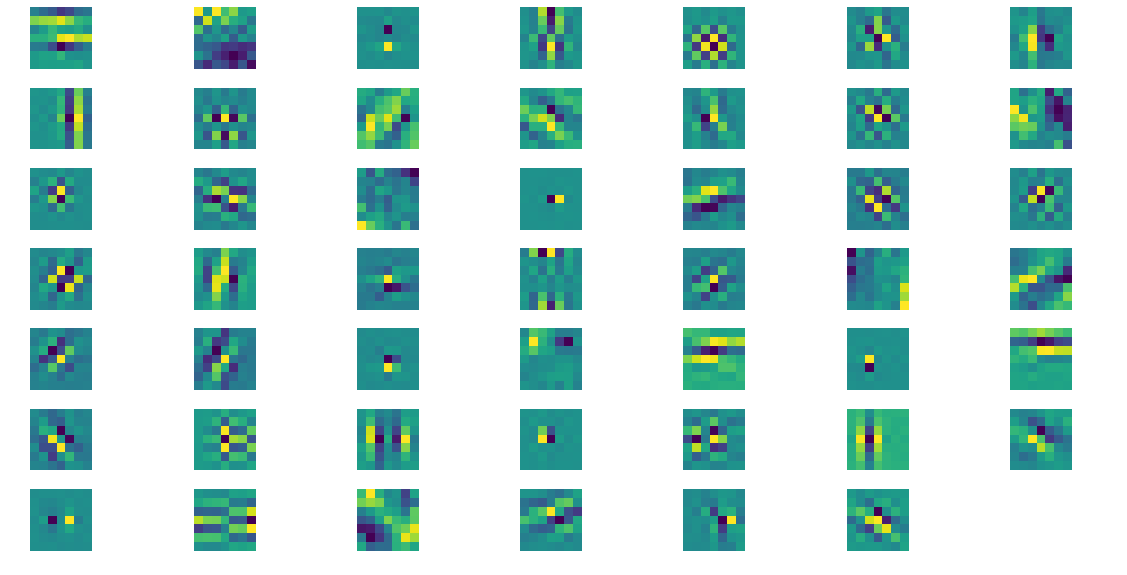

In [13]:
Sur.visualize(energy.operator)
img_denoised, _ = Sur.training_error(energy, loss, samples);
samples.redraw_noise()
img_denoised, _ = Sur.training_error(energy, loss, samples);

In [14]:
_, _ = Sur.testing_error(energy, loss, datasetTest, batch_size=25);
_, _ = Sur.testing_error(energy, loss, datasetTestFull);

TESTING | MSE: 0.001024 | avg PSNR for the given testset: 27.383, Time: 00:04 mins---
TESTING | MSE: 0.000974 | avg PSNR for the given testset: 27.417, Time: 00:27 mins---


### Visualization

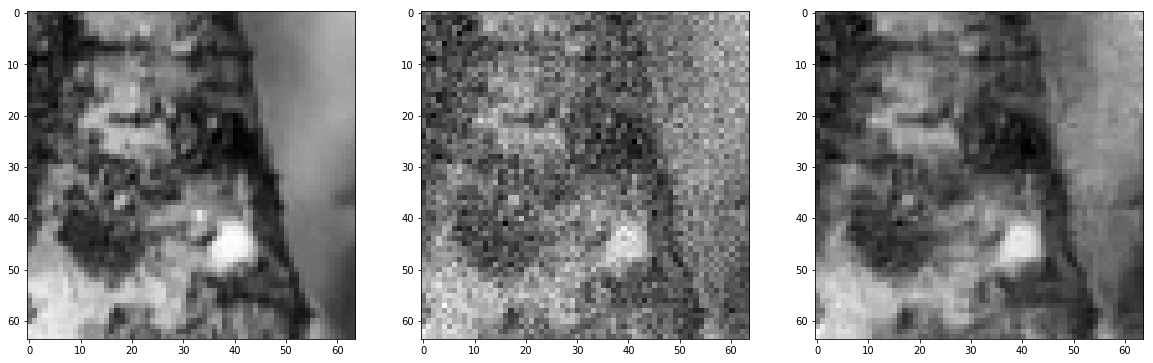

In [15]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(samples.y[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(img_denoised[0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()

In [16]:
layout = go.Layout(
         xaxis=dict(
             type='log',
             autorange=True,
             title='Iterations',
             automargin=True
             ),
         yaxis=dict(
             type='log',
             autorange  = True,
             title='Value',
             automargin=True
         ),
         )

data = [go.Scatter(y=optimizer.stats['loss'], name = 'Discriminator loss')]
fig = go.Figure(data=data, layout=layout)
ply.iplot(fig)

# 2) Iterated Parametric Majorization

In [17]:
iterative_setup = Sur.training.default_setup('IterativeLearning', algorithm)
iterative_setup

{'linearizer_iterations': 5,
 'tolerance': 1e-05,
 'extrapolation_choice': 'theta-k',
 'backtracking': 5,
 'check_loss': True,
 'verbose': True,
 'stochastic': False,
 'restart': True,
 'output': 'best-loss'}

In [18]:
# Define Model
energy = energy_setup(model_setup)
subroutine = Sur.training.DiscriminativeLearning(energy, loss, samples, training_setup, algorithm=algorithm)
optimizer =  Sur.training.IterativeLearning(subroutine, iterative_setup)
optimizer.run();

status: iteration    0, loss: 0.00586 (avg PSNR est: 19.307), tol: 100.000%
status: iteration 1000, loss: 0.00206 (avg PSNR est: 23.860), tol: 0.244%
status: iteration 2000, loss: 0.00205 (avg PSNR est: 23.879), tol: 0.007%
status: iteration 3000, loss: 0.00204 (avg PSNR est: 23.893), tol: 0.051%
status: iteration 4000, loss: 0.00203 (avg PSNR est: 23.910), tol: 0.023%
status: iteration 5000, loss: 0.00204 (avg PSNR est: 23.886), tol: 0.017%
status: iteration 6000, loss: 0.00207 (avg PSNR est: 23.838), tol: 0.056%
status: iteration 7000, loss: 0.00203 (avg PSNR est: 23.909), tol: 0.008%
status: finished  8000  iterations in 2 minutes and 47.63 seconds. tol: 0.039%
-- Iteration 0 done, tol: 100.000%, MSE: 0.000990, avg PSNR: 27.404
status: iteration    0, loss: 0.00334 (avg PSNR est: 21.757), tol: 100.000%
status: iteration 1000, loss: 0.00149 (avg PSNR est: 25.262), tol: 0.011%
status: iteration 2000, loss: 0.00149 (avg PSNR est: 25.254), tol: 0.050%
status: iteration 3000, loss: 0.001

Dictionary norm is 2.155.


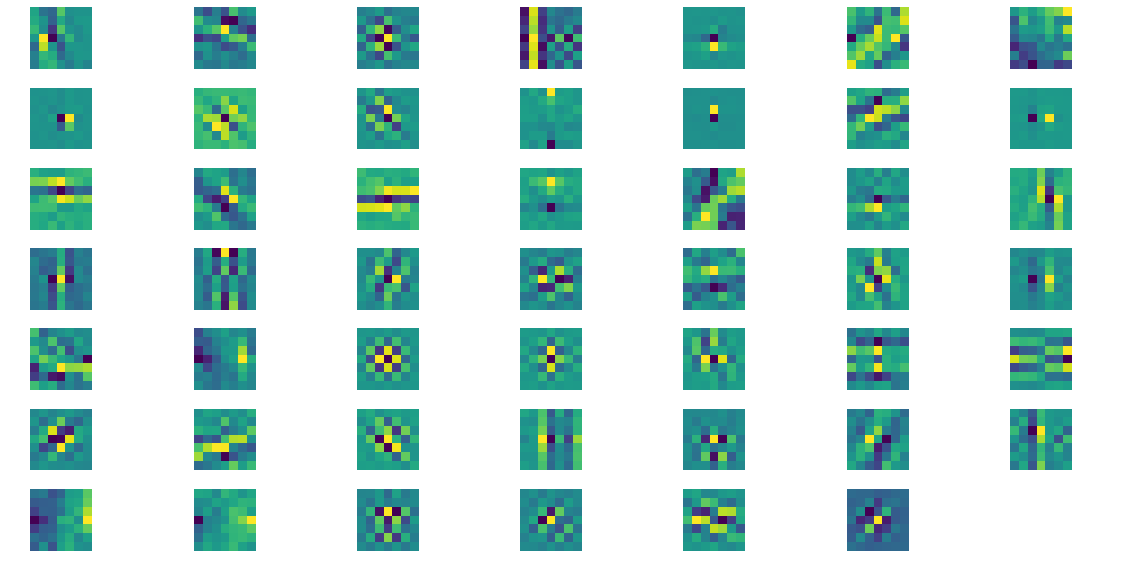

In [19]:
Sur.visualize(energy.operator);

### Validate training loss

In [20]:
img_denoised, _ = Sur.training_error(energy, loss, samples);
samples.redraw_noise()
img_denoised, _ = Sur.training_error(energy, loss, samples);

TRAINING | MSE: 0.000882 | avg PSNR for these samples: 28.506,  Time: 00:02 mins
TRAINING | MSE: 0.000881 | avg PSNR for these samples: 28.517,  Time: 00:02 mins


In [21]:
samples.reset()
samples.step()
img_denoised, _ = Sur.training_error(energy, loss, samples);

TRAINING | MSE: 0.000943 | avg PSNR for these samples: 28.454,  Time: 00:02 mins


### Save Model

In [22]:
data = model_setup, training_setup, iterative_setup, energy.state_dict()
path = './energies/'+algorithm+str(datetime.date.today()) + '.pt'
#torch.save(data, path)

### Test 

In [23]:
_, _ = Sur.testing_error(energy, loss, datasetTest, batch_size=25);
_, _ = Sur.testing_error(energy, loss, datasetTestFull, batch_size=4);

TESTING | MSE: 0.000914 | avg PSNR for the given testset: 28.524, Time: 00:04 mins---
TESTING | MSE: 0.000905 | avg PSNR for the given testset: 28.040, Time: 00:29 mins---


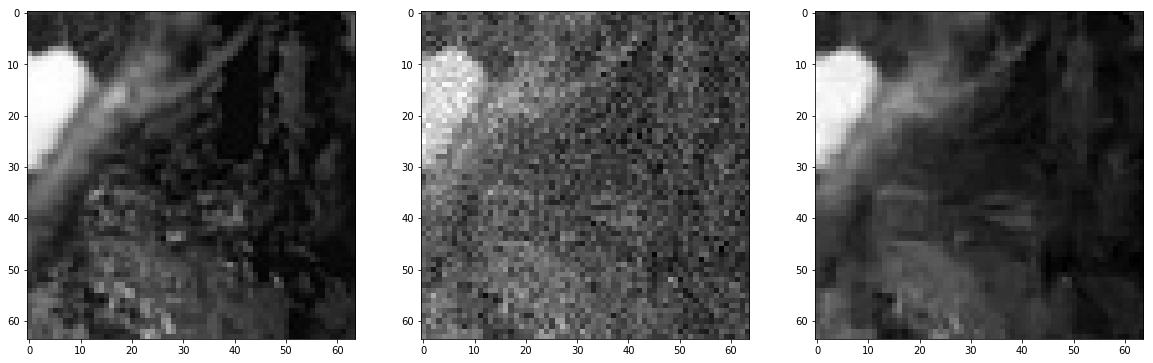

In [24]:
fig, axes = plt.subplots(1,3,figsize=(20, 10))
axes[0].imshow(samples.x[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[1].imshow(samples.y[0,:,:,].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
axes[2].imshow(img_denoised[0,:,:,:].permute(1, 2, 0).cpu().numpy().squeeze(), cmap='gray')
fig.canvas.draw()